In [1]:
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return continuation

class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

In [2]:
S, r, vol, T = 100, 0.03, 0.2, 1

from enum import Enum
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class PayoffType(str, Enum):
    Call = "Call"
    Put = "Put"
    
class Greeks(str, Enum):
    delta = "delta"
    gamma = "gamma"
    vega = "vega"
    theta = "theta"
    rho = "rho"

class GreekType():
    def __init__(self, n, calib, Greeks):
        self.n = n
        self.calib = calib
        self.greeks = Greeks
        
def binomialGreeks(S, r, vol, T, strike, option_type, payofftype, Greektype) -> float:
    delta_S = 0.1/100 * S
    option_value_s = lambda S: binomialPricer(S, r, vol, option_type(T, strike, payofftype), Greektype.n, Greektype.calib)
    delta_vol = 0.1/100
    option_value_vol = lambda vol: binomialPricer(S, r, vol, option_type(T, strike, payofftype), Greektype.n, Greektype.calib)
    delta_t = 0.004
    option_value_t = lambda T: binomialPricer(S,r, vol, option_type(T, strike, payofftype), Greektype.n, Greektype.calib)
    delta_r = 0.0001
    option_value_r = lambda r : binomialPricer(S, r, vol, option_type(T, strike, payofftype), Greektype.n, Greektype.calib)
    if Greektype.greeks == Greeks.delta:
        return (option_value_s(S + delta_S) - option_value_s(S - delta_S))/(2 * delta_S)
    elif Greektype.greeks == Greeks.gamma:
        return (option_value_s(S + delta_S) - 2 * option_value_s(S) + option_value_s(S - delta_S))/(delta_S)**2
    elif Greektype.greeks == Greeks.vega:
        return (option_value_vol(vol + delta_vol) - option_value_vol(vol - delta_vol))/(2 * delta_vol)
    elif Greektype.greeks == Greeks.theta:
        return (option_value_t(T-delta_t) - option_value_t(T))/delta_t
    elif Greektype.greeks == Greeks.rho:
        return (option_value_r(r + delta_r) - option_value_r(r - delta_r))/(2 * delta_r)

In [3]:
def greek_values(option_type, calib):
    greek_list = [Greeks.delta, Greeks.gamma, Greeks.vega, Greeks.theta, Greeks.rho]
    values_call, values_put = [], []
    calib_call, calib_put = {}, {}
    calib_table_call, calib_table_put = pd.DataFrame(), pd.DataFrame()
    
    for greeks in greek_list:
        for strike in range(50,150):
            values_call.append(binomialGreeks(S, r, vol, T, strike, option_type, PayoffType.Call, GreekType(100, calib, greeks)))
            calib_call[greeks] = values_call
    
    for x,y in enumerate(calib_call):
        calib_table_call[y] = calib_call[y][0 + 100*x :100 + 100*x]

    for greeks in greek_list:
        for strike in range(50,150):
            values_put.append(binomialGreeks(S, r, vol, T, strike, option_type, PayoffType.Put, GreekType(100, calib, greeks)))
            calib_put[greeks] = values_put
    
    for x,y in enumerate(calib_put):
        calib_table_put[y] = calib_put[y][0 + 100*x :100 + 100*x]
        
    return calib_table_call,calib_table_put

In [4]:
# crrCalib, jrrnCalib, jreqCalib, tianCalib
crr_greeks_euro = greek_values(EuropeanOption, crrCalib)
crr_greeks_amer = greek_values(AmericanOption, crrCalib)
jrrn_greeks_euro = greek_values(EuropeanOption, jrrnCalib)
jrrn_greeks_amer = greek_values(AmericanOption, jrrnCalib)
jreq_greeks_euro = greek_values(EuropeanOption, jreqCalib)
jreq_greeks_amer = greek_values(AmericanOption, jreqCalib)
tian_greeks_euro = greek_values(EuropeanOption, tianCalib)
tian_greeks_amer = greek_values(AmericanOption, tianCalib)

greeks_list = [crr_greeks_euro, crr_greeks_amer, jrrn_greeks_euro, jrrn_greeks_amer, \
               jreq_greeks_euro, jreq_greeks_amer, tian_greeks_euro, tian_greeks_amer]

In [5]:
def plotting_greeks(option_greeks : list, greek_index : int, euro : str, amer: str, greek_name):
    greeks = []
    
    for opt_greeks in option_greeks:
        for i in range(0,2):
            greeks.append(opt_greeks[i].iloc[ : ,greek_index])
            
    greek_dict = {}
    for keys, values in enumerate(greeks):
        greek_dict[keys] = values

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize = (12,6), nrows=2, ncols=2, sharex= True, sharey= False)
    fig.suptitle('{}'.format(greek_name))
    
    plt.xticks([50,75,100,125,150])
    strike = [k for k in range(50,150)]
    
    ax1.plot(strike, greek_dict[0], 'blue', label='{}_Call'.format(euro))
    ax1.plot(strike, greek_dict[1], 'red', label='{}_Put'.format(euro))
    ax1.plot(strike, greek_dict[2], 'orange', label='{}_Call'.format(amer))
    ax1.plot(strike, greek_dict[3], 'purple', label='{}_Put'.format(amer))
    ax1.set_xlabel('CRR_{}'.format(greek_name))
    ax1.grid(visible = True, color = "grey")

    ax2.plot(strike, greek_dict[4], 'blue', label='{}_Call'.format(euro))
    ax2.plot(strike, greek_dict[5], 'red', label='{}_Put'.format(euro))
    ax2.plot(strike, greek_dict[6], 'orange', label='{}_Call'.format(amer))
    ax2.plot(strike, greek_dict[7], 'purple', label='{}_Put'.format(amer))
    ax2.set_xlabel('JRRN_{}'.format(greek_name))
    ax2.grid(visible = True, color = "grey")

    ax3.plot(strike, greek_dict[8], 'blue', label='{}_Call'.format(euro))
    ax3.plot(strike, greek_dict[9], 'red', label='{}_Put'.format(euro))
    ax3.plot(strike, greek_dict[10], 'orange', label='{}_Call'.format(amer))
    ax3.plot(strike, greek_dict[11], 'purple', label='{}_Put'.format(amer))
    ax3.set_xlabel('JREQ_{}'.format(greek_name))
    ax3.grid(visible = True, color = "grey")
    
    ax4.plot(strike, greek_dict[12], 'blue', label='{}_Call'.format(euro))
    ax4.plot(strike, greek_dict[13], 'red', label='{}_Put'.format(euro))
    ax4.plot(strike, greek_dict[14], 'orange', label='{}_Call'.format(amer))
    ax4.plot(strike, greek_dict[15], 'purple', label='{}_Put'.format(amer))
    ax4.set_xlabel('TIAN_{}'.format(greek_name))
    ax4.grid(visible = True, color = "grey")
    
    ax1.legend(prop={'size': 8})
    ax2.legend(prop={'size': 8})
    ax3.legend(prop={'size': 8})
    ax4.legend(prop={'size': 8})

    plt.show()
    
greek_plot = {0 : "Delta", 1 : "Gamma", 2 : "Vega", 3 : "Theta", 4 : "Rho"}

### Greeks for european and american call and put for 4 different calibration 

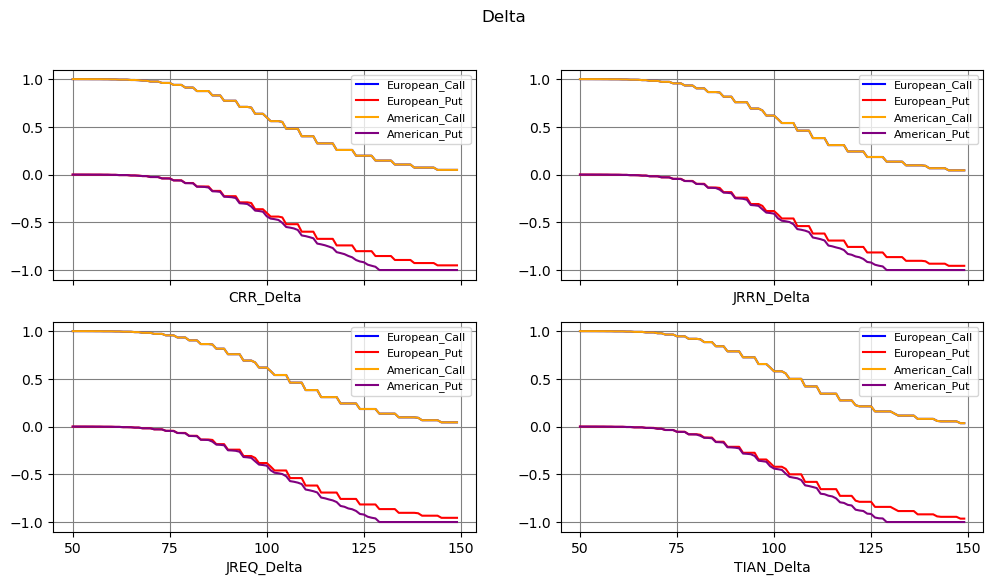

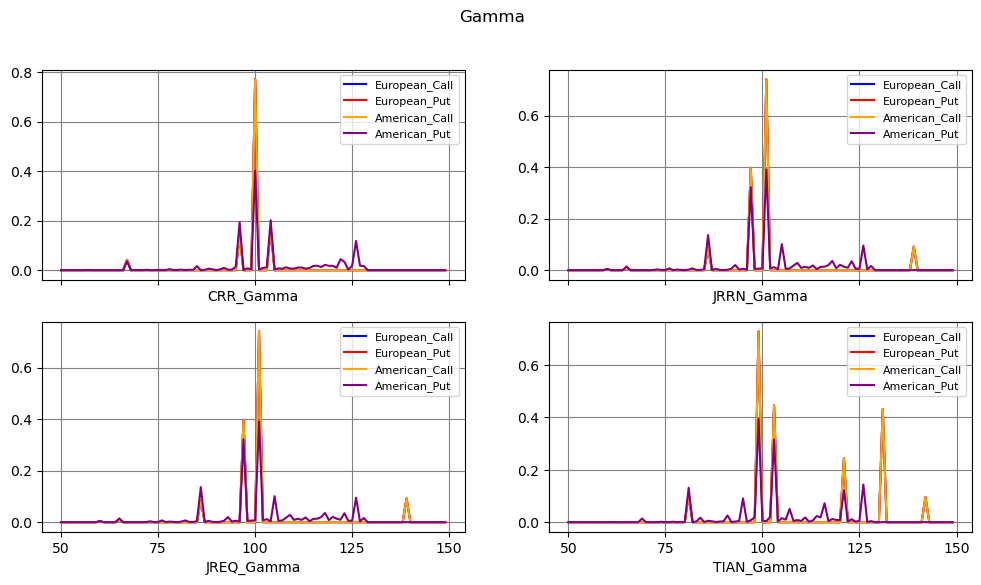

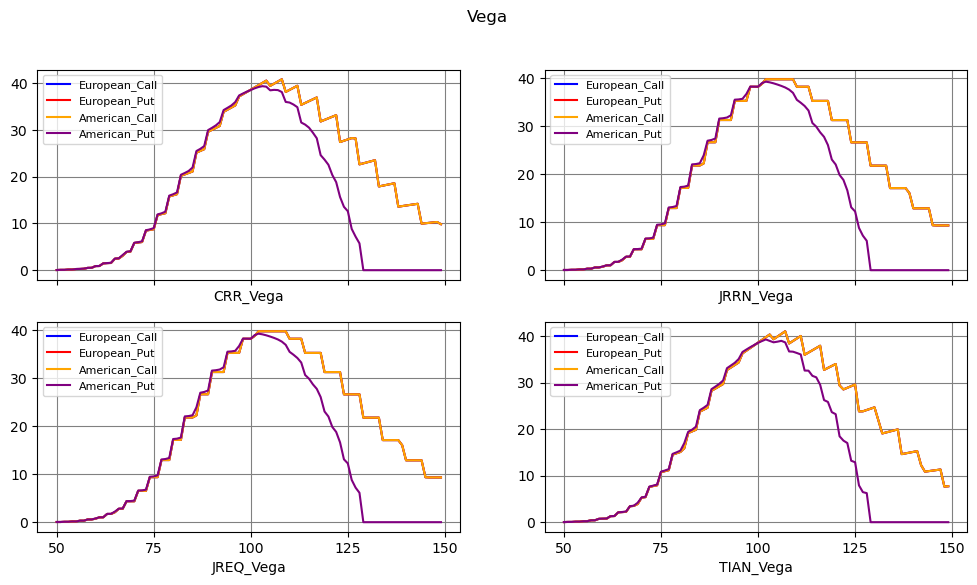

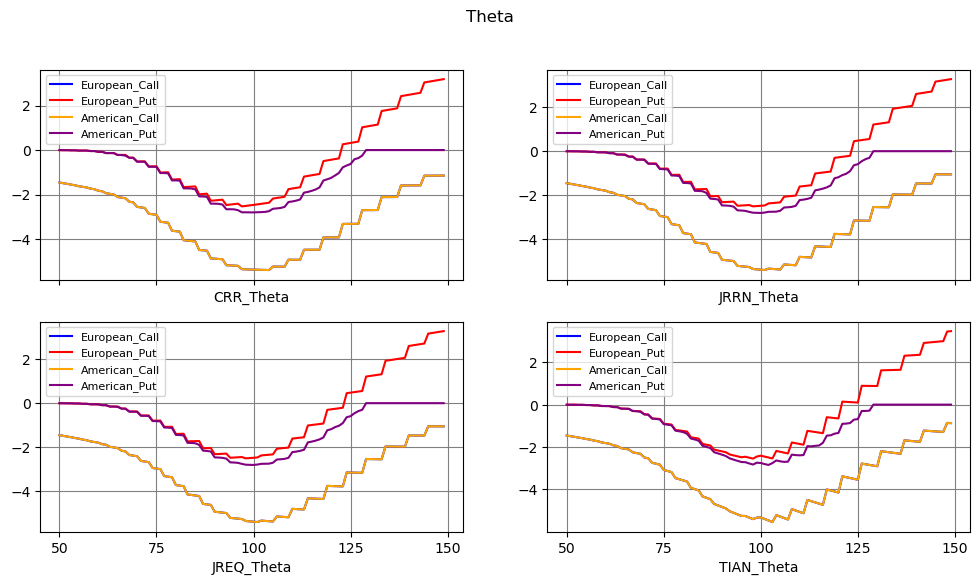

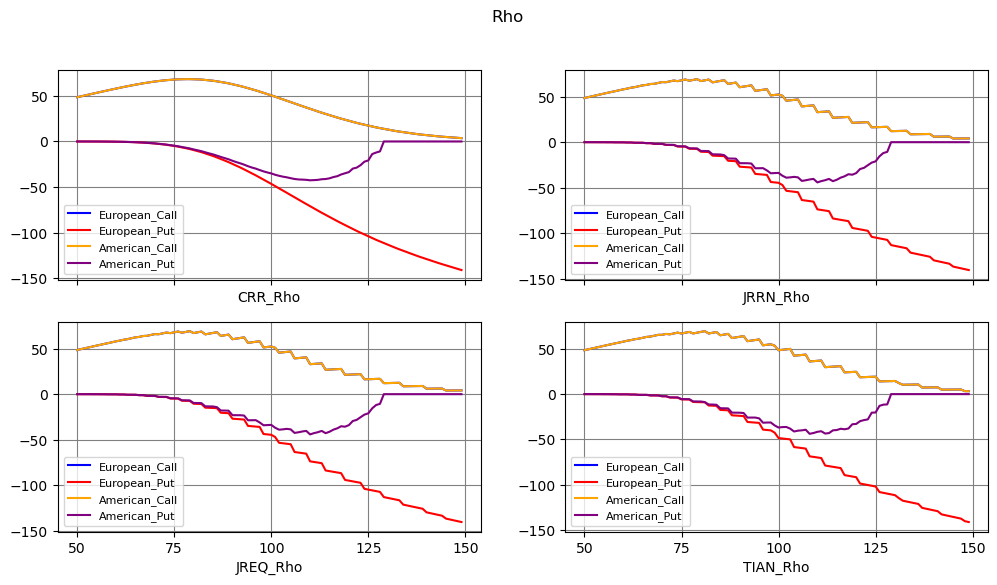

In [6]:
for keys, values in greek_plot.items():
    plotting_greeks(greeks_list, keys, "European", "American", values)